In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
from numpy import sqrt, random, array, argsort
from keras.models import Sequential
from keras.layers import Dense,LSTM
%matplotlib inline

##Matplotlib Parameters
import matplotlib.ticker as ticker
from pylab import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')


In [ ]:
df = pd.read_csv("/content/DD6P.csv")

df.head(5)

#df.tail(5)

#df.info

#df['Date'].describe()

#df.dtypes

#df.describe

,Date,Oil rate,Water rate,Gas rate,THP,BHP,GL,ESP
0,9/6/2014,1008,167,0,741,0,0,49
1,9/7/2014,1423,99,0,444,1615,0,49
2,9/8/2014,1460,79,0,453,1615,0,49
3,9/9/2014,1074,0,0,425,1659,0,49
4,9/10/2014,1352,9,0,424,1635,0,49


In [ ]:
##Deleting  Row with Error Values
#data = df[['Oil rate','THP','BHP','ESP']]
df = df[df['BHP']>0]
df[df.columns[5]] = df[df.columns[5]].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()

In [ ]:
##Checking Missing Values
df.isnull().sum()

Date          0
Oil rate      0
Water rate    0
Gas rate      0
THP           0
BHP           0
GL            0
ESP           0
dtype: int64

In [ ]:
##Filling Missing Values with Previous Day Value
df = df.fillna(method='ffill')
df.isnull().sum()

Date          0
Oil rate      0
Water rate    0
Gas rate      0
THP           0
BHP           0
GL            0
ESP           0
dtype: int64

In [ ]:
##Converting Date column as DateTime format
df['Date'] = pd.to_datetime(df['Date'],format="%m/%d/%Y")
df

,Date,Oil rate,Water rate,Gas rate,THP,BHP,GL,ESP
0,2014-09-06,1008,167,0,741,0,0,49
1,2014-09-07,1423,99,0,444,1615,0,49
2,2014-09-08,1460,79,0,453,1615,0,49
3,2014-09-09,1074,0,0,425,1659,0,49
4,2014-09-10,1352,9,0,424,1635,0,49
...,...,...,...,...,...,...,...,...
1429,2018-08-05,301,1452,0,305,1692,500,0
1430,2018-08-06,294,1417,0,308,1707,500,0
1431,2018-08-07,269,1445,0,301,1695,500,0
1432,2018-08-08,297,1447,0,268,1696,500,0


In [ ]:
##Setting Date as Index
df.set_index('Date',inplace=True)
df

,Oil rate,Water rate,Gas rate,THP,BHP,GL,ESP
Date,,,,,,,
2014-09-06,1008,167,0,741,0,0,49
2014-09-07,1423,99,0,444,1615,0,49
2014-09-08,1460,79,0,453,1615,0,49
2014-09-09,1074,0,0,425,1659,0,49
2014-09-10,1352,9,0,424,1635,0,49
...,...,...,...,...,...,...,...
2018-08-05,301,1452,0,305,1692,500,0
2018-08-06,294,1417,0,308,1707,500,0
2018-08-07,269,1445,0,301,1695,500,0


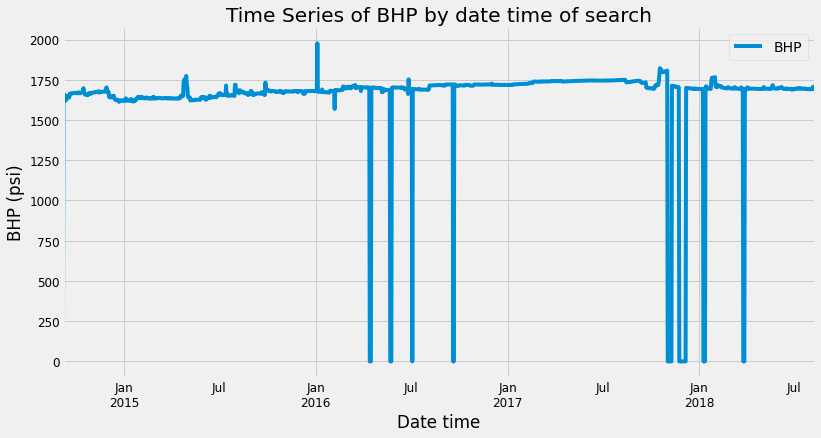

In [ ]:
# plot the data
df.plot( y='BHP', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('BHP (psi)')
plt.title('Time Series of BHP by date time of search');

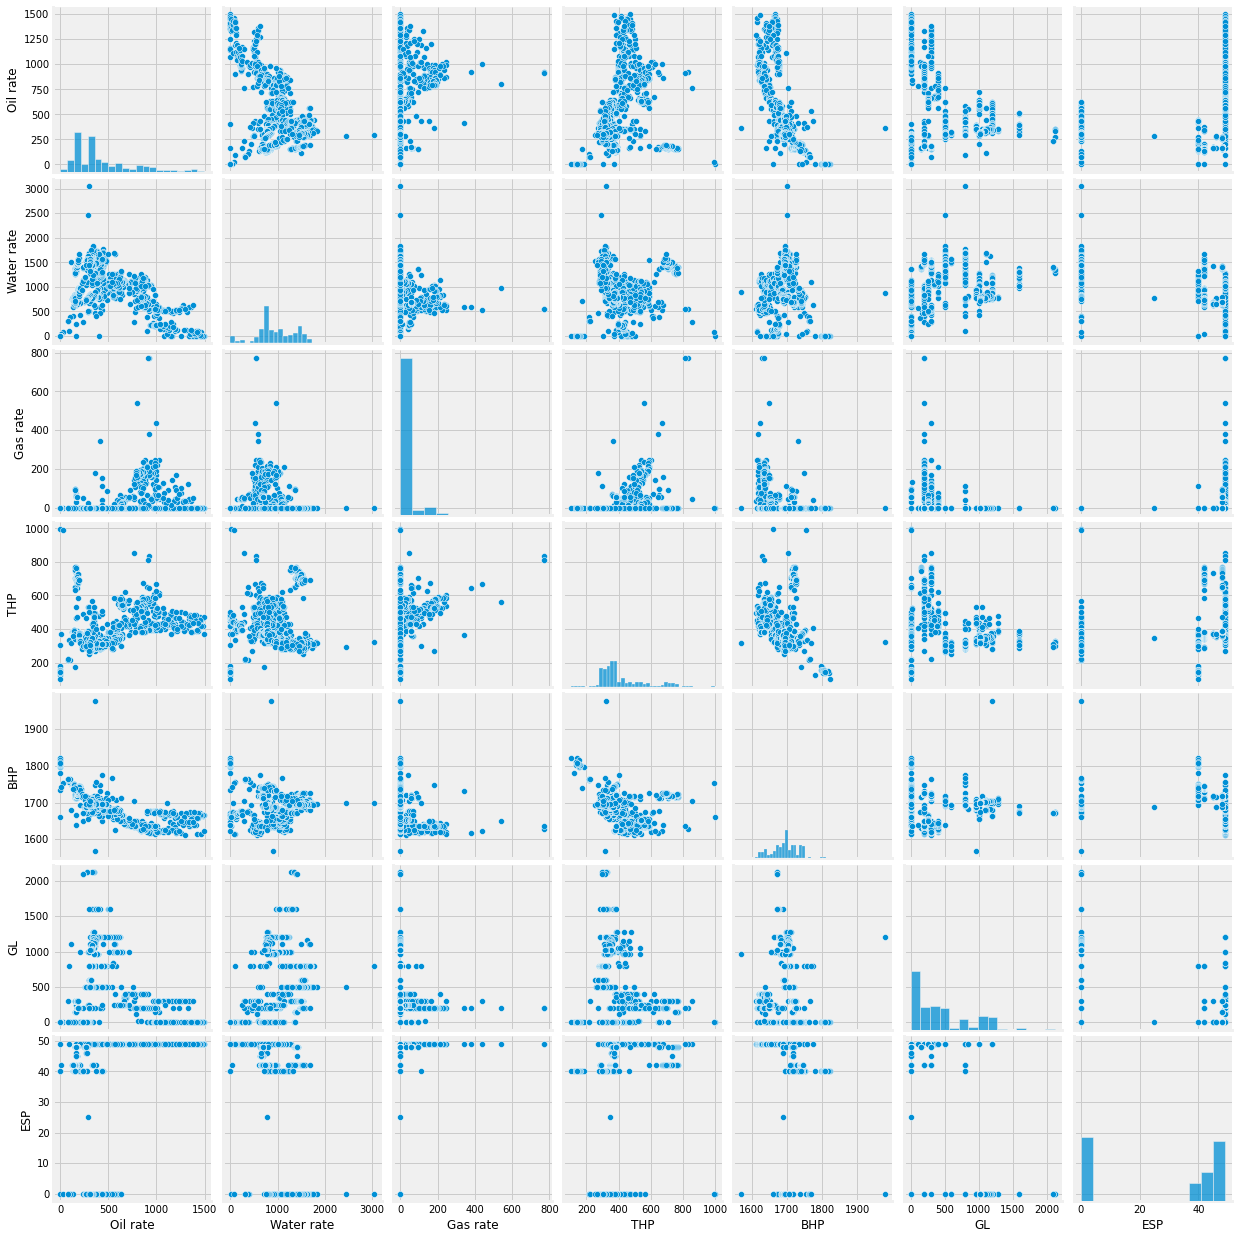

In [ ]:

sns.pairplot(df)

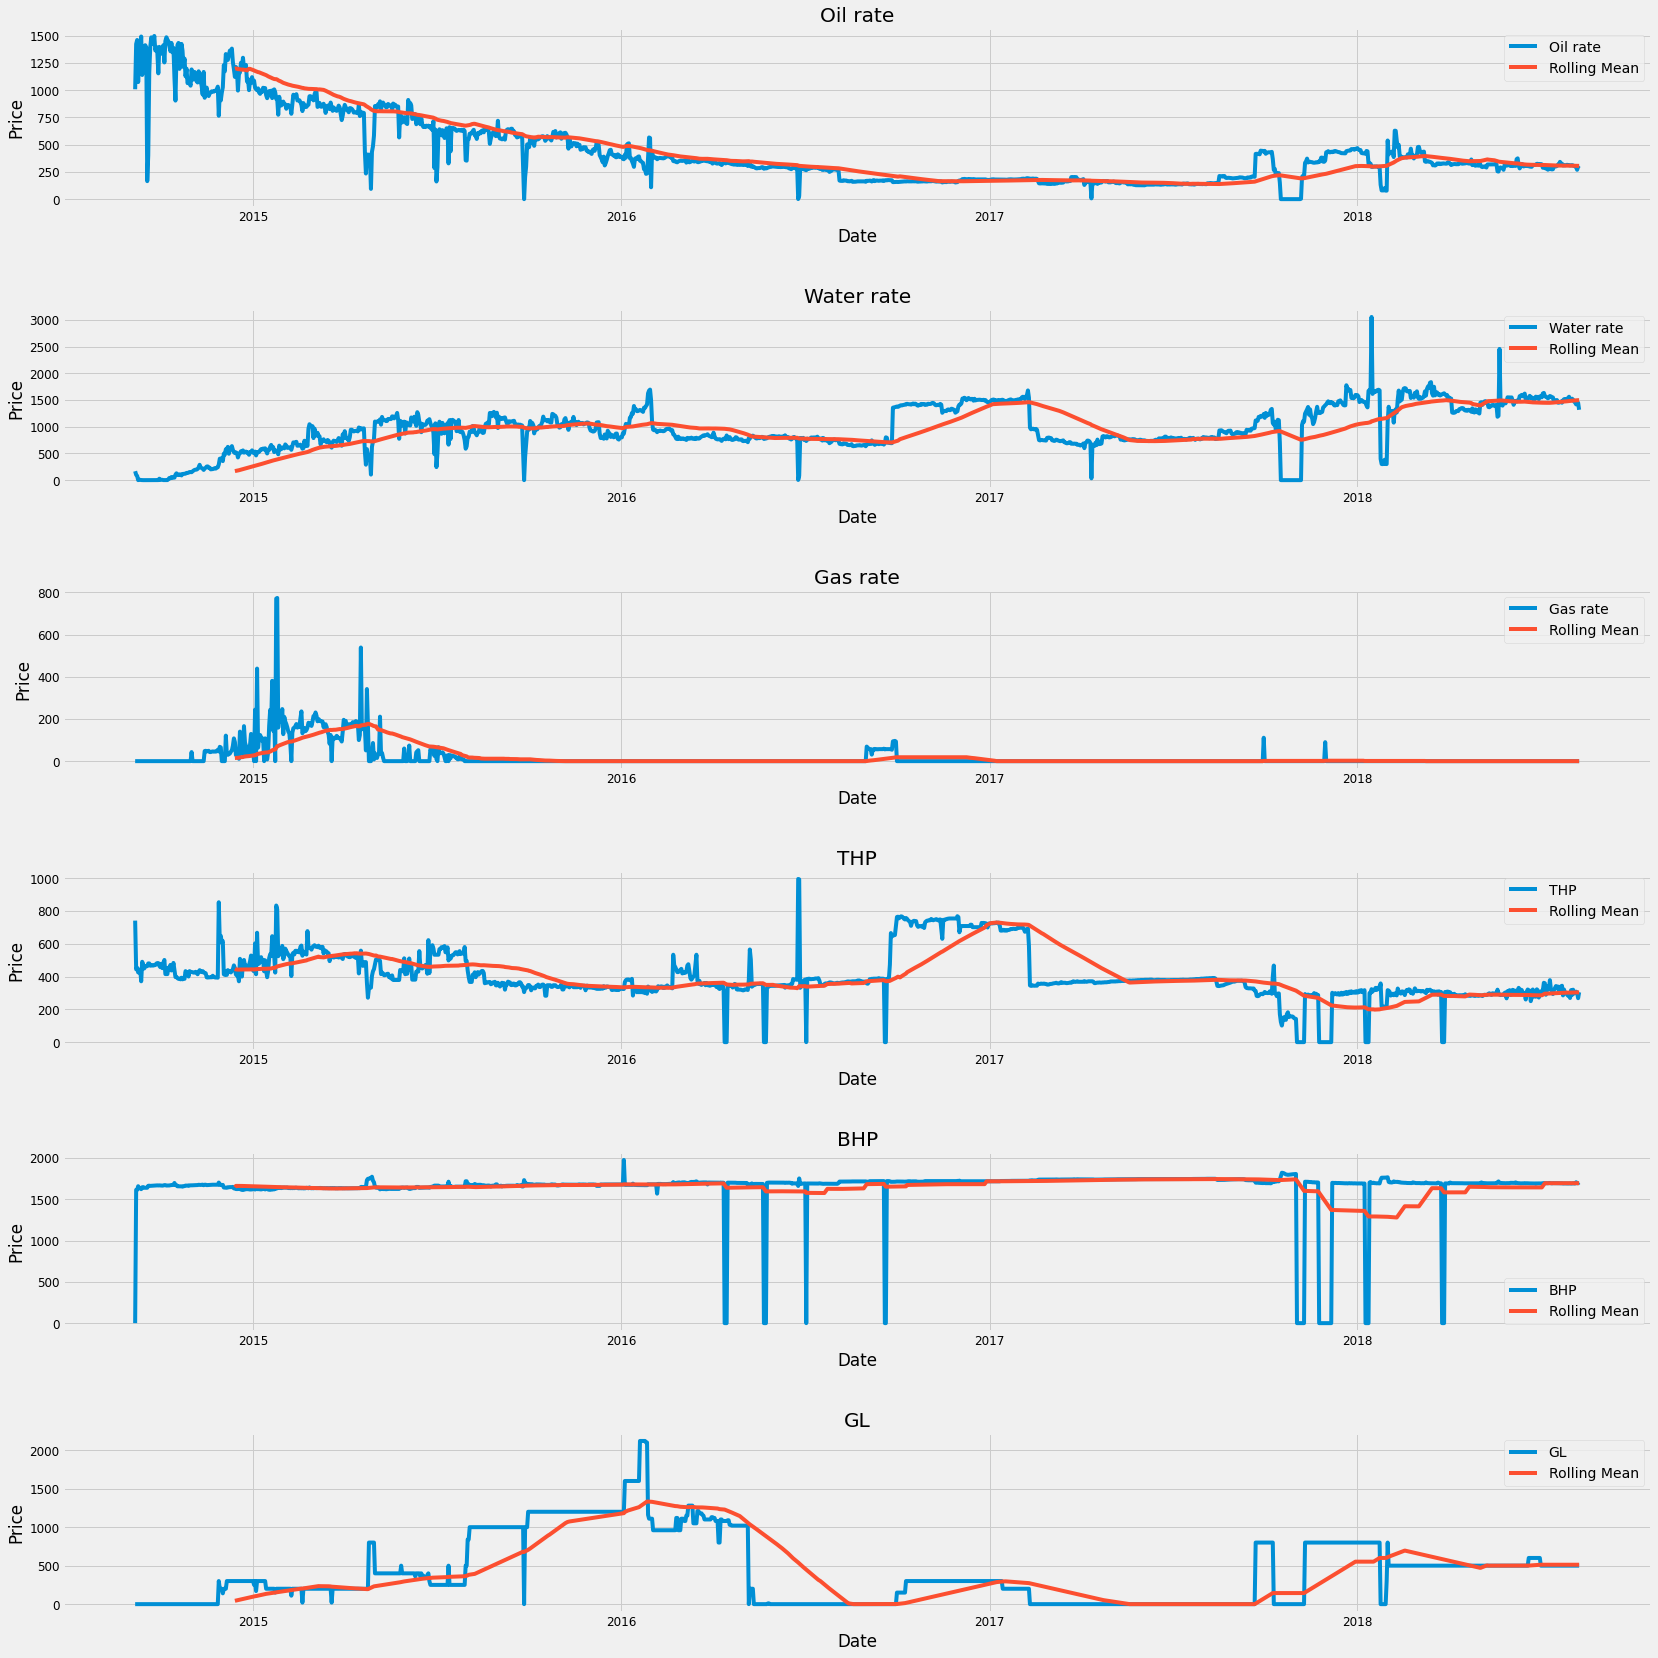

In [ ]:
##Line Plots Target & Features
data = df
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i])
  ax.xaxis.set_major_locator(md.YearLocator(base=1))
  ax.xaxis.set_major_formatter(md.DateFormatter("%Y"))
  ax.xaxis.set_tick_params(reset=True)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

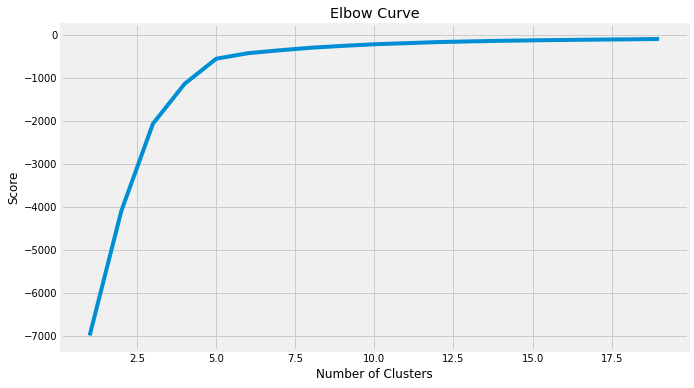

In [ ]:
#Clustering-Based Anomaly Detection
# k-means algorithm
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

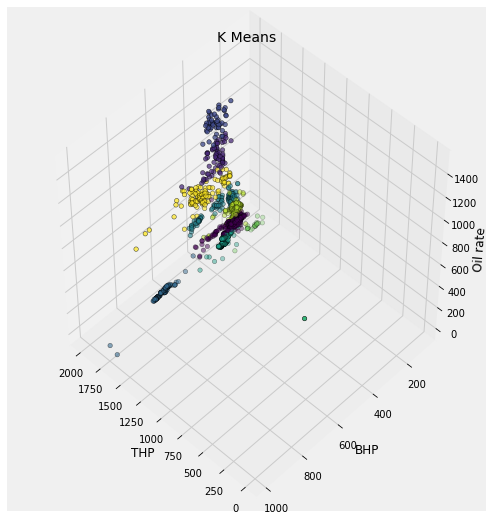

In [ ]:
X = df[['THP', 'BHP', 'Oil rate','ESP']]
X = X[X['BHP']>0]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("THP")
ax.set_ylabel("BHP")
ax.set_zlabel("Oil rate")
plt.title("K Means", fontsize=14);

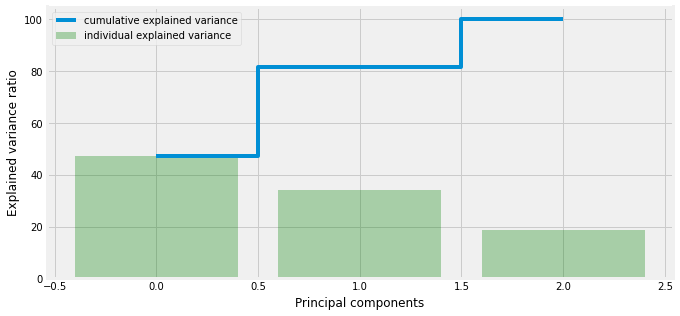

In [ ]:
from sklearn.preprocessing import StandardScaler
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [ ]:
# Take useful feature and standardize them
data = df[['BHP', 'THP', 'Oil rate']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [ ]:

kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

6    487
3    284
4    143
1    139
9     96
7     88
2     79
5     57
0     37
8     24
Name: cluster, dtype: int64

In [ ]:
df.head()

,Date,Oil rate,Gas rate,Water rate,BHP,THP,GL,ESP,anomaly3,cluster,principal_feature1,principal_feature2
0,9/6/2014,1008,167,0,741,0,0,49,-1.0,5,1.765954,3.711834
1,9/7/2014,1423,99,0,444,1615,0,49,-1.0,5,-0.541844,2.920922
2,9/8/2014,1460,79,0,453,1615,0,49,-1.0,5,-0.595257,3.032829
3,9/9/2014,1074,0,0,425,1659,0,49,1.0,2,-0.400230,1.849068
4,9/10/2014,1352,9,0,424,1635,0,49,1.0,5,-0.469554,2.681975


Clustering Approach

(1283, 11)

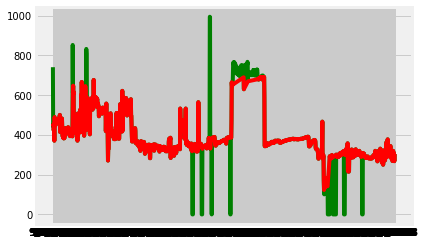

In [ ]:
# 1. Remove Outlier follow upper and lower bounds
lower_limit = df.BHP.mean() - 2*df.BHP.std()
lower_limit
upper_limit = df.BHP.mean() + 2*df.BHP.std()
upper_limit
df_no_outlier_std_dev = df[(df.BHP<upper_limit) & (df.BHP>lower_limit)]
plt.plot(df.Date,df.BHP,c='g')
plt.plot(df_no_outlier_std_dev.Date,df_no_outlier_std_dev.BHP,c='r')
df_no_outlier_std_dev.shape


(1283, 9)

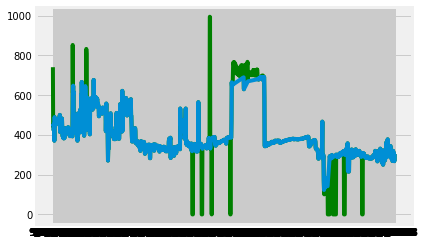

In [ ]:
# 2. Remove Outlier z-score
df['zscore'] = ( df.BHP- df.BHP.mean() ) / df.BHP.std()
df_no_outliers = df[(df.zscore>-2) & (df.zscore<2)]
plt.plot(df.Date,df.BHP,c='g')
plt.plot(df_no_outliers.Date,df_no_outliers.BHP)
df_no_outliers.shape

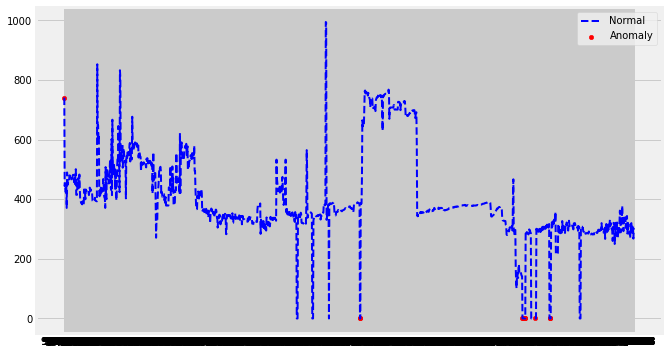

In [ ]:
#3. Isolation Forest for anomaly detection.
data = df[['BHP', 'THP', 'Oil rate']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

df['anomaly2'] = pd.Series(model.predict(data))
# df['anomaly2'] = df['anomaly2'].map( {1: 0, -1: 1} )

fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly2'] == -1, ['Date', 'BHP']] #anomaly

ax.plot(df['Date'], df['BHP'], color='blue', label = 'Normal', linestyle='dashed',linewidth=2)
ax.scatter(a['Date'],a['BHP'], color='red', label = 'Anomaly',s=20, marker='o')
plt.legend()
plt.show();

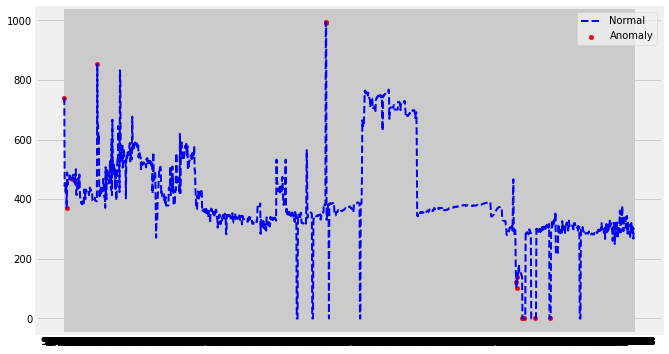

In [ ]:
# 4.Support Vector Machine-Based Anomaly Detection¶
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.05)
model.fit(data)
 
df['anomaly3'] = pd.Series(model.predict(data))
df
# df['anomaly3'] = df['anomaly3'].map( {1: 0, -1: 1} )
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly3'] == -1, ['Date', 'BHP']] #anomaly

ax.plot(df['Date'], df['BHP'], color='blue', label = 'Normal', linestyle='dashed',linewidth=2)
ax.scatter(a['Date'],a['BHP'], color='red', label = 'Anomaly',s=20,)
plt.legend()
plt.show();

**PREDICTION**

In [ ]:
#Importing necessary libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df = pd.read_csv("/content/DD6P.csv")

#df.head(5)

#df.tail(5)

#df.info

#df['Date'].describe()


#data = df[['Oil rate','THP','BHP','ESP']]
df = df[df['BHP']>0]
df[df.columns[5]] = df[df.columns[5]].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
df

,Date,Oil rate,Water rate,Gas rate,THP,BHP,GL,ESP
1,9/7/2014,1423,99,0,444,1615,0,49
2,9/8/2014,1460,79,0,453,1615,0,49
3,9/9/2014,1074,0,0,425,1659,0,49
4,9/10/2014,1352,9,0,424,1635,0,49
5,9/11/2014,1343,5,0,443,1637,0,49
...,...,...,...,...,...,...,...,...
1429,8/5/2018,301,1452,0,305,1692,500,0
1430,8/6/2018,294,1417,0,308,1707,500,0
1431,8/7/2018,269,1445,0,301,1695,500,0
1432,8/8/2018,297,1447,0,268,1696,500,0


In [ ]:
data = df.filter(['BHP'])
data = data[data['BHP']>0]
dataset = data.values
training_data_len = math.ceil(len(dataset)*.7)
training_data_len

978

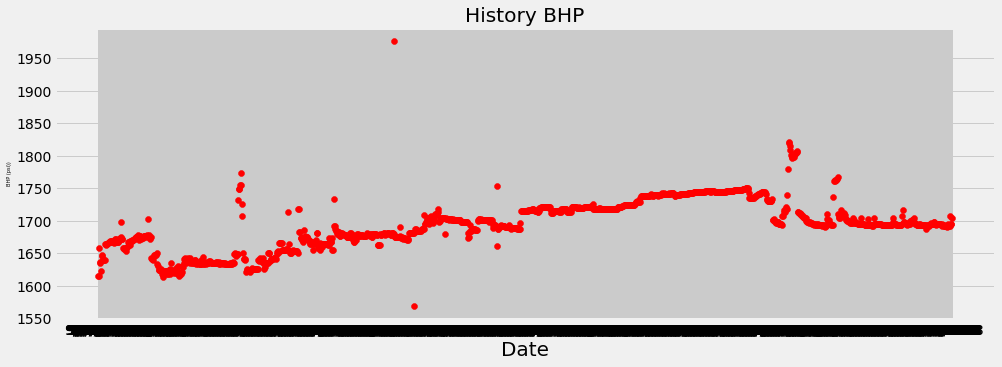

In [ ]:
name ='BHP'
#Plotting the the graph
plt.figure(figsize=(15,5))
plt.title('History '+ name)
plt.scatter(df['Date'],df['BHP'],c='Red')
plt.xlabel('Date', fontsize=20)
plt.ylabel('BHP (psi))', fontsize=5)
plt.show()

In [ ]:
#sale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.1127451 ],
       [0.1127451 ],
       [0.22058824],
       ...,
       [0.30882353],
       [0.31127451],
       [0.33333333]])

In [ ]:
# split into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [ ]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [ ]:
# reshape into X=t and Y=t+1
look_back =60
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/100
33/33 [==============================] - 25s 137ms/step - loss: 0.0123 - val_loss: 9.2671e-04
Epoch 2/100
33/33 [==============================] - 3s 83ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 3/100
33/33 [==============================] - 3s 82ms/step - loss: 0.0123 - val_loss: 0.0031
Epoch 4/100
33/33 [==============================] - 3s 84ms/step - loss: 0.0105 - val_loss: 0.0042
Epoch 5/100
33/33 [==============================] - 3s 83ms/step - loss: 0.0112 - val_loss: 0.0064
Epoch 6/100
33/33 [==============================] - 3s 82ms/step - loss: 0.0130 - val_loss: 0.0046
Epoch 7/100
33/33 [==============================] - 3s 83ms/step - loss: 0.0154 - val_loss: 9.2204e-04
Epoch 8/100
33/33 [==============================] - 3s 82ms/step - loss: 0.0091 - val_loss: 8.9653e-04
Epoch 9/100
33/33 [==============================] - 3s 84ms/step - loss: 0.0092 - val_loss: 9.0475e-04
Epoch 10/100
33/33 [==============================] - 3s 83ms/step - loss: 0.0089 

Train Mean Absolute Error: 22.817044718231664
Train Root Mean Squared Error: 28.38375106752092
Test Mean Absolute Error: 5.923065603595808
Test Root Mean Squared Error: 12.056701929540278


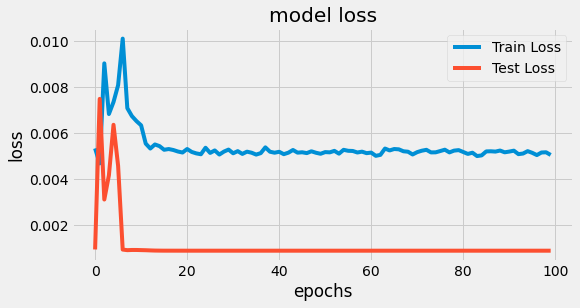

In [ ]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


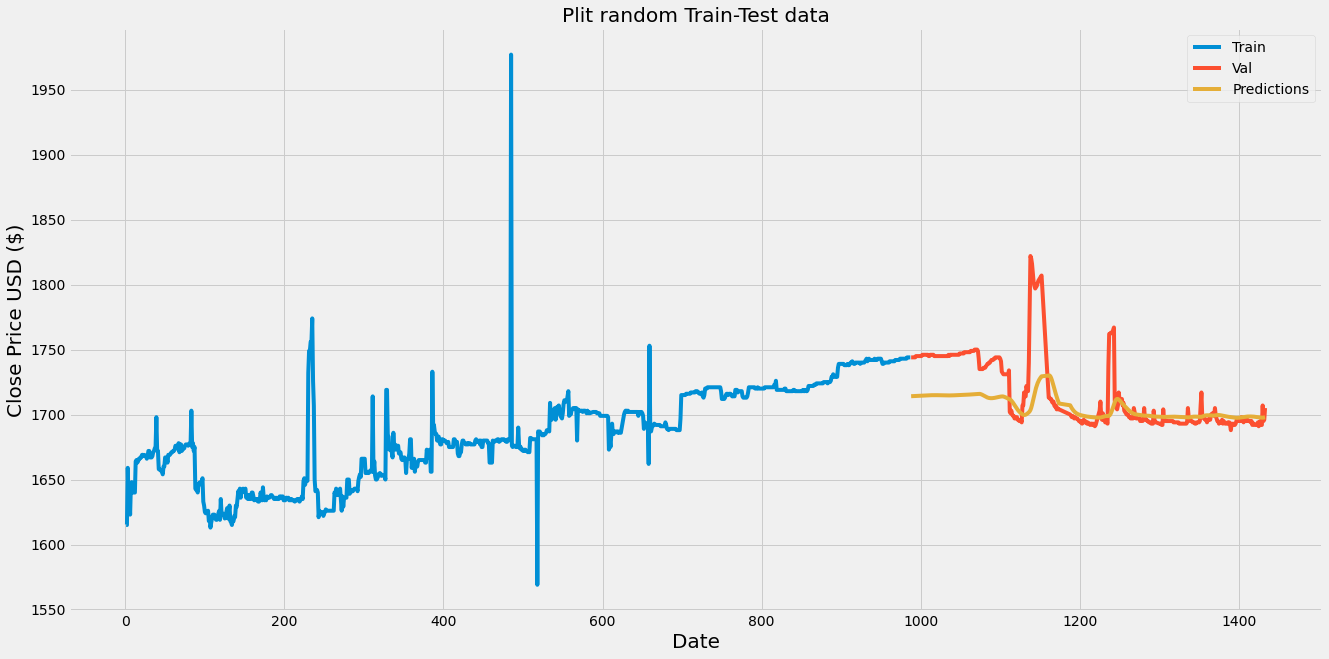

In [ ]:
#creatinf testing dataset
test_data = scaled_data[training_data_len - 30: , :]

#creating x_test and y_tets datasets
x_test = []
y_test = dataset[training_data_len:, :]
for i in range (30, len(test_data)):
  x_test.append(test_data[i -30:i, 0])

#converting data to numpy array
x_test = np.array(x_test)

#reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#get predicted price values
predictions = regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#plot the data

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#visualization
plt.figure(figsize=(20,10))
plt.title('Plit random Train-Test data')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD ($)', fontsize=20)
plt.plot(train['BHP'])
plt.plot(valid[['BHP', 'Predictions']])
plt.legend(['Train', 'Val','Predictions'], loc='upper right')
plt.show()

In [ ]:
dataset_test = data[-60:].values

inputs = dataset_test
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

i = 0
while i < 60:
    X_test = []
    no_of_sample = len(inputs)

    # Lay du lieu cuoi cung
    X_test.append(inputs[no_of_sample-60:no_of_sample, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Du doan gia
    predicted_stock_price = regressor.predict(X_test)

    # chuyen gia tu khoang (0,1) thanh gia that
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

    dataset_test = np.append(dataset_test, predicted_stock_price[0])
    inputs = dataset_test
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    print('Price next (' + str(i+1) + ') days : ', predicted_stock_price[0][0])
    i = i + 1

Price next (1) days :  1697.6921
Price next (2) days :  1697.8799
Price next (3) days :  1698.0643
Price next (4) days :  1698.2356
Price next (5) days :  1698.3903
Price next (6) days :  1698.5282
Price next (7) days :  1698.6501
Price next (8) days :  1698.7579
Price next (9) days :  1698.853
Price next (10) days :  1698.9371
Price next (11) days :  1699.0109
Price next (12) days :  1699.0757
Price next (13) days :  1699.1322
Price next (14) days :  1699.1819
Price next (15) days :  1699.2251
Price next (16) days :  1699.2628
Price next (17) days :  1699.2957
Price next (18) days :  1699.3242
Price next (19) days :  1699.3491
Price next (20) days :  1699.3711
Price next (21) days :  1699.3903
Price next (22) days :  1699.4071
Price next (23) days :  1699.4219
Price next (24) days :  1699.4352
Price next (25) days :  1699.4468
Price next (26) days :  1699.4572
Price next (27) days :  1699.4664
Price next (28) days :  1699.4746
Price next (29) days :  1699.482
Price next (30) days :  1

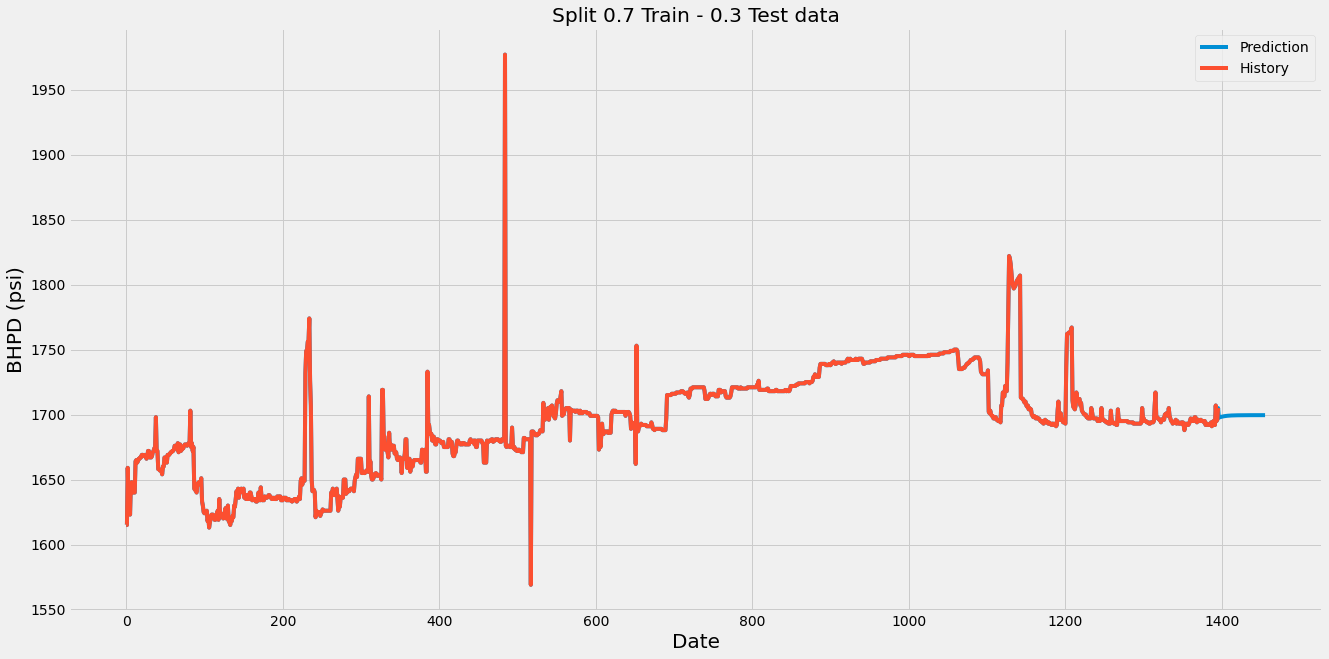

In [ ]:
dataset_pre = np.append(data['BHP'], dataset_test[60:])

#visualization
plt.figure(figsize=(20,10))
plt.title('Split 0.7 Train - 0.3 Test data')
plt.xlabel('Date', fontsize=20)
plt.ylabel('BHPD (psi)', fontsize=20)
plt.plot(dataset_pre)
plt.plot(dataset[:])
plt.legend(['Prediction', 'History'], loc='upper right')
plt.show()

**Multivariate LSTM**

In [ ]:
#Importing necessary libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df = pd.read_csv("/content/DD6P.csv")

df = df[df['BHP']>0]
df = df.set_index('Date')
#df = df.dropna(axis=1,  )
df[df.columns[5]] = df[df.columns[5]].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
df.dtypes

Oil rate      int64
Water rate    int64
Gas rate      int64
THP           int64
BHP           int64
GL            int64
ESP           int64
dtype: object

In [ ]:
# Multivariate LSTM
# Defining the inputs and output of the LSTM model so as to create the sequences
input_1 =df['Oil rate'].values
input_2 = df['THP'].values
input_3 = df['ESP'].values
input_4 = df['GL'].values
output_feat = df['BHP'].values


# Reshaping for converting the inputs/output to 2d shape
input_1 = input_1.reshape((len(input_1), 1))
input_2 = input_2.reshape((len(input_2), 1))
input_3 = input_3.reshape((len(input_3), 1))
input_4 = input_4.reshape((len(input_4), 1))
output_feat = output_feat.reshape((len(output_feat), 1))

In [ ]:
# Use of hstack to put together the input sequence arrays horizontally (column wise)
from numpy import hstack
df = hstack((input_1, input_2,input_3,input_4))
df[:5]

array([[1423,  444,   49,    0],
       [1460,  453,   49,    0],
       [1074,  425,   49,    0],
       [1352,  424,   49,    0],
       [1343,  443,   49,    0]])

In [ ]:
# Selecting the length of each sequence and the size of the prediction horizon (forecast_steps)
seq_len= 15
pred_horizon=60
# Splitting the dataset into training and test set (y_test -->to compare the LSTM forecasts for given inputs (X_test))
X_train=df[:-pred_horizon]
y_train=output_feat[:-pred_horizon]
X_test=df[-pred_horizon:]
y_test=output_feat[-pred_horizon:]

In [ ]:
# The shape of training and test data
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1336, 4) (1336, 1)
(60, 4) (60, 1)


In [ ]:
# MinMaxScaler is used to transform dataset columns by scaling them between 0 & 1.Training samples are first fitted 
# and then transformed, whereas the test samples are transformed based on the previously fitted training samples in order
# to avoid forecasting with a biased ML model.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train=scaler.fit_transform(y_train)
y_test=scaler.transform(y_test)

In [ ]:
# Function to create the input-output sequence. Each train batch consists of 12 inputs & the corresponding 
# y_target value (one step-ahead)
from numpy import array

def set_seq(seq, seq_len):
    X = []
    y = []
    for t in range(len(seq)-seq_len):
        end = t + seq_len # End index is equal to the current index plus the specified number of sequence length
        
        if end> len(seq)-1:# if the length of the formed train sequence is greater than the length of the input feature,stop
            break
# for seq_length=12 : X_input seq. ->12 (indices 0-11) past observations, y_target -> 1 observation at one time step ahead
# (index 12)
        Xseq= seq[t:end, :-1]
        y_target =seq[end, -1]
        X.append(Xseq)
        y.append(y_target)
    return array(X), array(y) #initializing the arrays

In [ ]:
# Use of hstack to put together the train sequence arrays horizontally 
df_train = hstack((X_train,y_train))
# Creating the training sequences
Xtrain_seq,ytrain_seq=set_seq(df_train, seq_len)

In [ ]:

# The input training data have been converted into 3d shape--> [sample_length,seq_len, number of input features]
print(Xtrain_seq.shape)

(1321, 15, 4)


In [ ]:
# Presenting the first two training sequences. As it can be observed, the first 12 input entries (seq_len=12),
# i.e. The current index input value at time step 12 and the past 11 observations for each feature, together with the
# GOOGL Close price at time step 13 (one-step ahead),comprise the first sequence.
# In the second batch, the sequence is updated by dropping the first input values and appending the next X-y values
# at the end of the batch.
# As it can be observed, the first two y target values correspond to the y_train values with indices 12 and 13 for
# time steps 13 and 14 respectively
for t in range(2):
    print(Xtrain_seq[t], ytrain_seq[t])
print('\r')
print('The first two ytrain_seq values correspond to the  train target values (y_train) with indexes 12 and 13 : ')
print(y_train[12:14])

[[0.9505678  0.3836689  1.         0.        ]
 [0.9752839  0.39373602 1.         0.        ]
 [0.71743487 0.36241611 1.         0.        ]
 [0.90313961 0.36129754 1.         0.        ]
 [0.89712759 0.38255034 1.         0.        ]
 [0.99665999 0.30201342 1.         0.        ]
 [0.76085504 0.43512304 1.         0.        ]
 [0.90714763 0.41498881 1.         0.        ]
 [0.93052772 0.38926174 1.         0.        ]
 [0.94321977 0.4049217  1.         0.        ]
 [0.93119572 0.4049217  1.         0.        ]
 [0.11022044 0.4049217  1.         0.        ]
 [0.26920508 0.42393736 1.         0.        ]
 [0.7742151  0.42393736 1.         0.        ]
 [0.93319973 0.4082774  1.         0.        ]] 0.23284313725490158
[[0.9752839  0.39373602 1.         0.        ]
 [0.71743487 0.36241611 1.         0.        ]
 [0.90313961 0.36129754 1.         0.        ]
 [0.89712759 0.38255034 1.         0.        ]
 [0.99665999 0.30201342 1.         0.        ]
 [0.76085504 0.43512304 1.         0.  

In [ ]:
# Defining the number of input features
features_num = Xtrain_seq.shape[2]
features_num

4

In [ ]:

# Reshaping the target train data to be inserted into the LSTM model in the required dimension
ytrain_seq=ytrain_seq.reshape((-1,1))
ytrain_seq.shape

(1321, 1)

In [ ]:
# Importing the necessary libraries to create/construct the neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import initializers
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)
# Use of the he_uniform initializer to set the initial weights 
initializer = tf.keras.initializers.he_uniform(seed=0)
model = Sequential()
# Use of 12 neurons--> equal to the length of an input train sequence
model.add(LSTM(12, activation='relu',  input_shape=(seq_len, features_num),kernel_initializer=initializer ))

# The output layer consists of 1 neuron with a 'linear' activation fuction
model.add(Dense(1,activation='linear'))
# The model is compiled with selected loss function= 'mse', whereas the selected optimizer is 'adam' with a learning rate
# of 0.001, epsilon=1e-8 and with the default values of the exponential decay rates for the first and second moment estimates
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8)

model.compile(optimizer=opt, loss='mse')

# Fitting the LSTM model 
model.fit( Xtrain_seq, ytrain_seq,epochs=30, batch_size=1, shuffle=False,verbose=0)

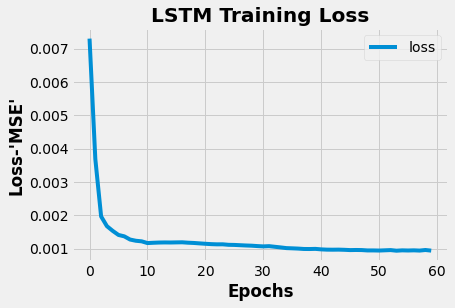

In [ ]:
# Training loss plot
loss = pd.DataFrame(model.history.history)
loss.plot()
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold');

In [ ]:
# Determining all LSTM training set predictions so as to compare them with the actual GOOGL Close training values 

train_lstm_outputs = []
train_batch = Xtrain_seq[0].reshape((1, seq_len, features_num))

for i in range(len(Xtrain_seq[1:])):
    train_lstm_out = model.predict(train_batch)[0]
    train_lstm_outputs.append(train_lstm_out)
    train_batch=Xtrain_seq[1:][i].reshape((1, seq_len, features_num))
    
#Append train_lstm_output from last train batch    
train_lstm_outputs.append(model.predict(train_batch)[0])

In [ ]:

# Last appended input to the final train sequence (train_batch) is X_train[-2]. 
# The X_train[-1] is to be appended to the input sequence after training to determine the first forecasted value 
# This is because the model is trained to predict one step ahead 
print('Final train batch (sequence): \n')
print(train_batch)
print("\r")
print('Last appended input of the final train batch: \n')
print(X_train[-2])

Final train batch (sequence): 

[[[0.17969272 0.21029083 0.         0.23584906]
  [0.20975284 0.22259508 0.         0.23584906]
  [0.21576486 0.22595078 0.         0.23584906]
  [0.20507682 0.18568233 0.         0.23584906]
  [0.20841683 0.23489933 0.         0.23584906]
  [0.20774883 0.23042506 0.         0.23584906]
  [0.20908484 0.24161074 0.         0.23584906]
  [0.20307281 0.20917226 0.         0.23584906]
  [0.20908484 0.21252796 0.         0.23584906]
  [0.20240481 0.24384787 0.         0.23584906]
  [0.20440882 0.21588367 0.         0.23584906]
  [0.20374081 0.2393736  0.         0.23584906]
  [0.20374081 0.21812081 0.         0.23584906]
  [0.24515698 0.23378076 0.         0.23584906]
  [0.249833   0.2393736  0.         0.23584906]]]

Last appended input of the final train batch: 

[0.249833   0.2393736  0.         0.23584906]


In [ ]:

# Applying the inverse_transform function to get the original values
predictions=scaler.inverse_transform(train_lstm_outputs)
predictions=predictions.reshape((-1,1))

In [ ]:
# Applying the inverse_transform function to the ytrain_seq set
ytrain_seq=scaler.inverse_transform(ytrain_seq)

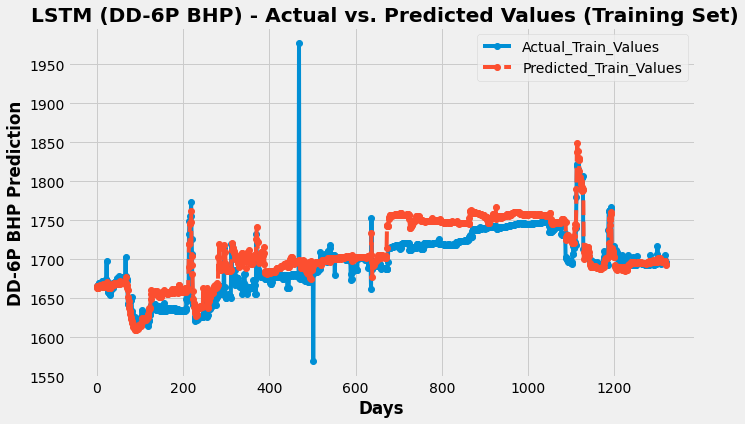

In [ ]:
# LSTM Training Performance - Actual vs. Predicted Training Set Values for 198 training steps (198 training sequences)

plt.figure(figsize=(10,6))
plt.plot(ytrain_seq,marker='o',linestyle='-')

plt.plot(predictions,marker='o',linestyle='dashed')
plt.title(' LSTM (DD-6P BHP) - Actual vs. Predicted Values (Training Set)',fontweight='bold')
plt.legend(('Actual_Train_Values','Predicted_Train_Values'))
plt.xlabel('Days',fontweight='bold')
plt.ylabel('DD-6P BHP Prediction',fontweight='bold');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


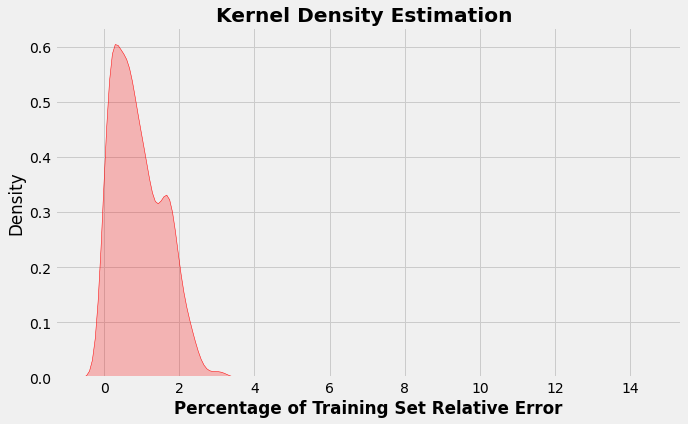

In [ ]:
# Training relative Error Percentage distribution plot
trainset_error=abs((ytrain_seq-predictions)/ytrain_seq)*100
trainset_error=pd.DataFrame(trainset_error,columns=['Training Set Error'])
plt.figure(figsize=(10,6))
sns.kdeplot(trainset_error['Training Set Error'],shade=True,color='r',kernel='gau',)
plt.xlabel('Percentage of Training Set Relative Error',fontweight='bold')
plt.title('Kernel Density Estimation ',fontweight='bold');

In [ ]:
 #Summary statistics of training relative error

trainset_error.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Training Set Error,1324.0,0.918536,0.782833,0.000414,0.346925,0.770453,1.415942,14.047288


In [ ]:
# Determining the Root Mean Squared Error of the training set predicted values and the actual_train values
RMSE=np.sqrt(mean_squared_error(ytrain_seq,predictions))
RMSE=RMSE.round(2)
RMSE

20.79

**Time Series Forecasting & comparison with Test**

In [ ]:
# Creating the first batch to forecast the first GOOGL Close price.
# First batch consists of the final train batch, where the last X train input (X_train[-1]) is appended 
first_batch=np.append(train_batch[:,1:,:],[[X_train[-1].reshape((1,features_num))]])
first_batch=first_batch.reshape((1, seq_len, features_num))
print('First Batch - step-ahead prediction: \n ',first_batch)
print('\r')
print ('Appended Input: \n',X_train[-1])

First Batch - step-ahead prediction: 
  [[[0.20975284 0.22259508 0.         0.23584906]
  [0.21576486 0.22595078 0.         0.23584906]
  [0.20507682 0.18568233 0.         0.23584906]
  [0.20841683 0.23489933 0.         0.23584906]
  [0.20774883 0.23042506 0.         0.23584906]
  [0.20908484 0.24161074 0.         0.23584906]
  [0.20307281 0.20917226 0.         0.23584906]
  [0.20908484 0.21252796 0.         0.23584906]
  [0.20240481 0.24384787 0.         0.23584906]
  [0.20440882 0.21588367 0.         0.23584906]
  [0.20374081 0.2393736  0.         0.23584906]
  [0.20374081 0.21812081 0.         0.23584906]
  [0.24515698 0.23378076 0.         0.23584906]
  [0.249833   0.2393736  0.         0.23584906]
  [0.20574482 0.25727069 0.         0.23584906]]]

Appended Input: 
 [0.20574482 0.25727069 0.         0.23584906]


In [ ]:
# Determining all LSTM predicted values so as to compare them with the actual test values 
lstm_outputs = []
batch =first_batch

# loop to determine the other predictions based on the X_test inputs that are appended to the batch
for i in range(len(X_test)):
    lstm_out = model.predict(batch)[0]
    lstm_outputs.append(lstm_out) 
    
# The first row of the current batch sequence is dropped, and the next X_test input is placed at the end of the batch
    batch = np.append(batch[:,1:,:],[[X_test[i]]],axis=1)

In [ ]:
# Applying the inverse_transform function to the predicted values to get their true values
lstm_predictions=scaler.inverse_transform(lstm_outputs)
lstm_predictions

array([[1695.52981782],
       [1698.11281586],
       [1697.67972422],
       [1696.60466766],
       [1696.94964051],
       [1697.90660548],
       [1697.68187642],
       [1698.47368097],
       [1697.31854296],
       [1697.37104702],
       [1697.79965186],
       [1698.36739612],
       [1700.37508678],
       [1699.68762159],
       [1697.89496899],
       [1698.89246106],
       [1698.61534953],
       [1698.27925301],
       [1696.85810494],
       [1697.13276029],
       [1698.33209753],
       [1697.32622766],
       [1697.62208891],
       [1696.67097259],
       [1698.43710566],
       [1697.79093361],
       [1698.76058078],
       [1700.82627153],
       [1700.06047583],
       [1700.46613598],
       [1701.04635572],
       [1699.49303555],
       [1701.44813704],
       [1701.50008178],
       [1701.82718039],
       [1699.17527533],
       [1698.54724503],
       [1698.27262616],
       [1698.24793053],
       [1697.15810037],
       [1697.48517466],
       [1695.190

In [ ]:
# Applying the inverse_transform function to the y_test set
y_test=scaler.inverse_transform(y_test)

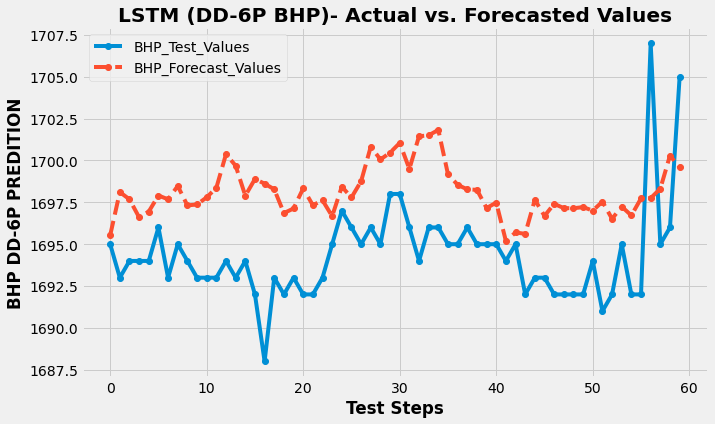

In [ ]:
# Plot of the Test vs. Predicted results for a prediction horizon of 52 weeks
plt.figure(figsize=(10,6))
plt.plot(y_test,marker='o',linestyle='-')
plt.plot(lstm_predictions,marker='o',linestyle='dashed')
plt.title('LSTM (DD-6P BHP)- Actual vs. Forecasted Values',fontweight='bold')
plt.legend(('BHP_Test_Values','BHP_Forecast_Values'))
plt.xlabel('Test Steps',fontweight='bold')
plt.ylabel('BHP DD-6P PREDITION',fontweight='bold');

In [ ]:
pr = pd.read_csv("/content/DD6P_Predict.csv")

pr = pr[pr['BHP']>0]
pr = pr.set_index('Date')
#df = df.dropna(axis=1,  )
pr[pr.columns[5]] = pr[pr.columns[5]].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
pr.dtypes

Oil rate      int64
Water rate    int64
Gas rate      int64
THP           int64
BHP           int64
GL            int64
ESP           int64
dtype: object

In [ ]:
# Multivariate LSTM
# Defining the inputs and output of the LSTM model so as to create the sequences
input_1 =pr['Oil rate'].values
input_2 = pr['THP'].values
input_3 = pr['ESP'].values
input_4 = pr['GL'].values
output_feat = pr['BHP'].values


# Reshaping for converting the inputs/output to 2d shape
input_1 = input_1.reshape((len(input_1), 1))
input_2 = input_2.reshape((len(input_2), 1))
input_3 = input_3.reshape((len(input_3), 1))
input_4 = input_4.reshape((len(input_4), 1))
output_feat = output_feat.reshape((len(output_feat), 1))

# Use of hstack to put together the input sequence arrays horizontally (column wise)
from numpy import hstack
df = hstack((input_1, input_2,input_3,input_4))
df[:5]

array([[310, 276,   0, 500],
       [311, 275,   0, 500],
       [310, 255,   0, 500],
       [312, 295,   0, 500],
       [287, 298,   0, 500]])

In [ ]:
X_pre=df[:]
y_pre=output_feat[:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
#X_train = scaler.fit_transform(X_train)
X_pre = scaler.fit_transform(X_pre)
#y_train=scaler.fit_transform(y_train)
y_pre=scaler.fit_transform(y_pre)

In [ ]:
# Creating the first batch to forecast the first GOOGL Close price.
# First batch consists of the final train batch, where the last X train input (X_train[-1]) is appended 
first_batch=np.append(train_batch[:,1:,:],[[X_pre[-1].reshape((1,features_num))]])
first_batch=first_batch.reshape((1, seq_len, features_num))
print('First Batch - step-ahead prediction: \n ',first_batch)
print('\r')
print ('Appended Input: \n',X_pre[-1])

First Batch - step-ahead prediction: 
  [[[0.20975284 0.22259508 0.         0.23584906]
  [0.21576486 0.22595078 0.         0.23584906]
  [0.20507682 0.18568233 0.         0.23584906]
  [0.20841683 0.23489933 0.         0.23584906]
  [0.20774883 0.23042506 0.         0.23584906]
  [0.20908484 0.24161074 0.         0.23584906]
  [0.20307281 0.20917226 0.         0.23584906]
  [0.20908484 0.21252796 0.         0.23584906]
  [0.20240481 0.24384787 0.         0.23584906]
  [0.20440882 0.21588367 0.         0.23584906]
  [0.20374081 0.2393736  0.         0.23584906]
  [0.20374081 0.21812081 0.         0.23584906]
  [0.24515698 0.23378076 0.         0.23584906]
  [0.249833   0.2393736  0.         0.23584906]
  [0.42757009 0.27795276 0.         0.625     ]]]

Appended Input: 
 [0.42757009 0.27795276 0.         0.625     ]


In [ ]:
# Determining all LSTM predicted values so as to compare them with the actual test values 
lstm_outputs = []
batch = first_batch

# loop to determine the other predictions based on the X_test inputs that are appended to the batch
for i in range(len(X_pre)):
    lstm_out = model.predict(batch)[0]
    lstm_outputs.append(lstm_out) 
    
# The first row of the current batch sequence is dropped, and the next X_test input is placed at the end of the batch
    batch = np.append(batch[:,1:,:],[[df[i]]],axis=1)

In [ ]:
# Applying the inverse_transform function to the predicted values to get their true values
lstm_predictions=scaler.inverse_transform(lstm_outputs)
lstm_predictions

In [ ]:
# Applying the inverse_transform function to the y_test set
y_pre=scaler.inverse_transform(y_pre)

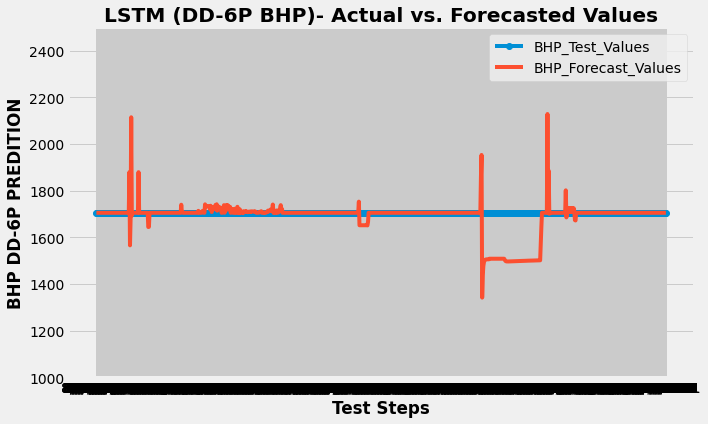

In [ ]:
# Plot of the Test vs. Predicted results for a prediction horizon of 52 weeks
plt.figure(figsize=(10,6))
plt.plot(y_pre,marker='o',linestyle='-')
plt.plot(lstm_predictions)

plt.title('LSTM (DD-6P BHP)- Actual vs. Forecasted Values',fontweight='bold')
plt.legend(('BHP_Test_Values','BHP_Forecast_Values'))
plt.ylim(1000,2500)
plt.xlabel('Test Steps',fontweight='bold')
plt.ylabel('BHP DD-6P PREDITION',fontweight='bold');

In [ ]:
pr['BHP_pre'] = lstm_predictions[:]
pr

,Oil rate,Water rate,Gas rate,THP,BHP,GL,ESP,BHP_pre
Date,,,,,,,,
8/10/2018,310,1284,0,276,1705,500,0,1705.278208
8/11/2018,311,1274,0,275,1705,500,0,1705.232314
8/12/2018,310,1286,0,255,1705,500,0,1705.232314
8/13/2018,312,1312,0,295,1705,500,0,1705.232314
8/14/2018,287,1240,0,298,1705,500,0,1705.232314
...,...,...,...,...,...,...,...,...
3/27/2021,182,1339,0,362,1705,500,0,1705.232314
3/28/2021,181,1328,0,358,1705,500,0,1705.232314
3/29/2021,181,1320,0,358,1705,500,0,1705.232314


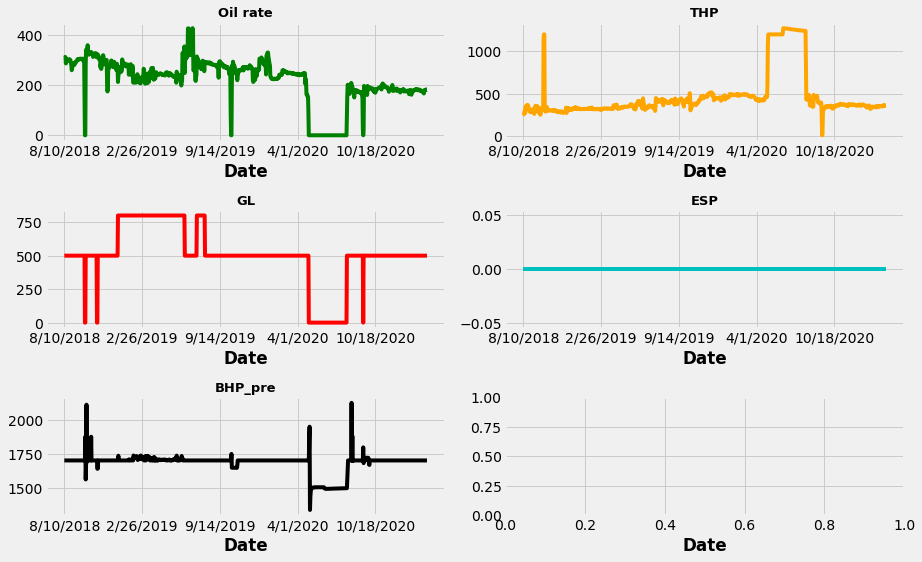

In [ ]:
# Average Weekly value Plots of Global Active Power, Global Reactive Power,Global Intensity and Voltage from 2006-12 to 2010-12
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(13,8))

pr['Oil rate'].plot(ax=axes[0,0],color='g')
axes[0,0].set_title('Oil rate',fontweight='bold',fontsize=13)


pr['THP'].plot(ax=axes[0,1],color='orange')
axes[0,1].set_title('THP',fontweight='bold',fontsize=13)


pr['GL'].plot(ax=axes[1,0],color='r')
axes[1,0].set_title('GL',fontweight='bold',fontsize=13)


pr['ESP'].plot(ax=axes[1,1],color='c')
axes[1,1].set_title('ESP',fontweight='bold',fontsize=13)

pr['BHP_pre'].plot(ax=axes[2,0],color='black')
axes[2,0].set_title('BHP_pre',fontweight='bold',fontsize=13)


for ax in axes.flat:
    
    ax.figure.tight_layout(pad=1)
    ax.set_xlabel('Date',fontweight='bold')

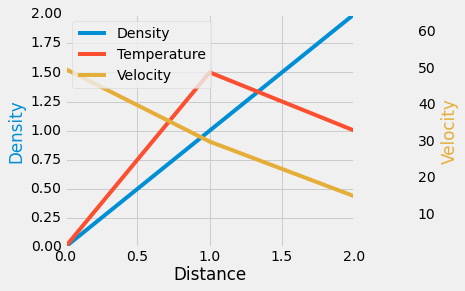

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlim(0, 2)
host.set_ylim(0, 2)

host.set_xlabel("Distance")
host.set_ylabel("Density")
par1.set_ylabel("Temperature")
par2.set_ylabel("Velocity")

p1, = host.plot([0, 1, 2], [0, 1, 2], label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], label="Temperature")
p3, = par2.plot([0, 1, 2], [50, 30, 15], label="Velocity")

par1.set_ylim(0, 4)
par2.set_ylim(1, 65)

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

plt.draw()
plt.show()

#plt.savefig("Test")

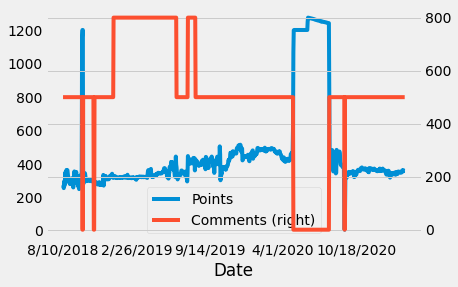

In [ ]:
pr.THP.plot(label="Points", legend=True)
pr.GL.plot(secondary_y=True, label="Comments", legend=True)
